# 1. Giriş

Zaman serileri çözümlemesindeki temel süreçlerden birisi "durağan" (stationary) olasılıksal süreçtir. **Durağan süreç**, ortalaması ve varyansı zaman içerisinde değişmeyen ve iki dönem arasındaki kovaryansın ise bakılan döneme değil de dönemlerin arasındaki uzaklığa bağlı olduğu süreçtir.

Aşağıdaki gibi bir $Y_{t}$ serisi tanımlayalım:

$$
\begin{aligned}
E\left(Y_{t}\right) &=\mu \\
\operatorname{var}\left(Y_{t}\right) &=\gamma_{0} \\
\operatorname{cov}\left(Y_{t}, Y_{t+k}\right) &=\gamma_{k}
\end{aligned}
$$

Şimdi, başlangıç noktasını t'den $t+k$ 'ye kaydırdığımızı düşünelim. Eğer $Y$ durağan ise $Y_{t}$ ve $Y_{t+k}$ serilerinin ortalama, varyans ve kovaryansları aynı olmalıdır. $k=0$ olduğunda $\operatorname{cov}\left(Y_{t}, Y_{t+0}\right)=\operatorname{var}\left(Y_{t}\right)=\sigma^{2}$ 'dir.

Tanımımıza göre durağan bir zaman serisi; ortalaması, varyansı ve kovaryansı zamandan bağımsız olan seridir. Böyle bir seri, kendi ortalaması çevresinde sabit genişlikte salınımlar gösterir. Bu özelliğe **ortalamaya dönüş (mean reversion)** de denir. Bu şekildeki durağan seriler yazında farklı adlandırmalarla karșımıza çıkabilmektedir:

* zayıf durağan (weakly stationary).
* kovaryans durağan (covariance stationary).
* ikinci-derece durağan (second-order stationary).

Zaman serileri ile yapılan ampirik çalışmalarda verilerin "durağan" olduğu varsayılmaktadır. Fakat zaman serilerinin önemli bir kısmı durağan değildir. Değişkenler arasındaki ilişkilerin anlamlı olabilmesi için kullandığımız zaman serilerinin durağan özellikler göstermesi gerekmektedir. İki değişken arasında anlamlı ilişkiler olmamasına rağmen aralarında ilişki varmış gibi görünebilir. Bu serilerle bir bağlanım modeli kurduğumuzda aralarında ilişki olmasa bile yüksek bir $\mathrm{R}^{2}$ değeri elde edilebilir. Bu durumda **sahte bağlanım (spurious regression)** problemi ortaya çıkmış olacaktır. Bu sorunun kaynağı şudur: Her iki zaman serisi de güçlü bir trende sahipse aralarında gözlenen yüksek $R^{2}$ 'nin sebebi; söz konusu iki değişken arasındaki doğrusal ilişki değil, bu güçlü trend ilişkisidir. Dolayısıyla durağan olmayan seriler ile analiz yapıldığında geleneksel $t$ ve $F$ testleri ile $\mathrm{R}^{2}$ değeri yanıltıcı sonuçlar vermektedir.

Bu yazıda, Türkiye için 1998-2021 dönemine ait yıllık GSYH ve hanehalkı tüketim verilerinin logaritmik biçimini ele alacağız: 

In [1]:
import warnings
warnings.filterwarnings("ignore")

# gerekli çerçevelerin içeri alınması
import pandas as pd
import numpy as np

# evdsAPI modülünün içeri aktarılması
from evds import evdsAPI

# Merkez Bankasından alınan ücretsiz API anahtarının tanımlanması
evds = evdsAPI('BedQlkxC57')

# makro iktisadi verilerin içeri alınıp düzenlenmesi
makro_veri = evds.get_data(['TP.GSYIH26.HY.CF', 'TP.GSYIH20.HY.CF'], startdate='01-01-1998', enddate='01-01-2021', frequency=8)
makro_veri = makro_veri.rename(columns={'TP_GSYIH26_HY_CF':'gsyh', 'TP_GSYIH20_HY_CF':'tuketim'})
makro_veri['log_gsyh'] = np.log(makro_veri['gsyh'])
makro_veri['log_tuketim'] = np.log(makro_veri['tuketim'])
makro_veri = makro_veri.drop(['gsyh', 'tuketim'], axis=1)
makro_veri = makro_veri.set_index('Tarih')

Şimdi serilerin grafiğini çizelim:

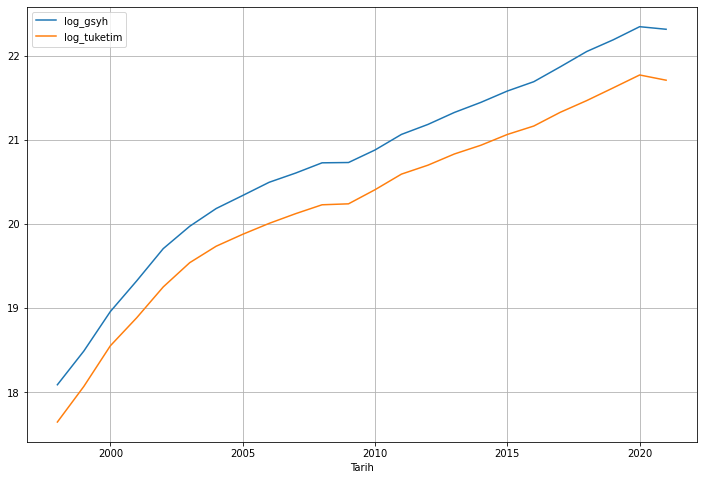

In [2]:
import matplotlib.pyplot as plt

makro_veri.plot(figsize=(12, 8))
plt.grid()

Durağanlığın tespiti için biçimsel olmayan ve biçimsel yöntemler sıklıkla kullanılmaktadır. Burada durağanlığın tespiti için biçimsel yöntemler olan bazı birim kök testlerini ele alacağız. Bazı testler için, sonuç çıktılarını hem standart hem de biçimsel tablolar halinde sunabilmek adına küçük bir kod betiği hazırladık. Betiğe [buradan](https://gist.github.com/homodigitus/99b5529d79732b8cafeca3cf524b3c08) ulaşabilirsiniz. Kod betiğindeki fonksiyonları içeri alalım:

In [3]:
from unit_root_tests import *

# 2. Birim Kök Testleri

Durağanlığı sınamak için uygulamada en yaygın kullanılan yöntemlerden birisi birim kök analizidir. Daha önce belirtildiği gibi

$$
\mid Y_{t}=\alpha_{1} Y_{t-1}+u_{t}
$$

süreci düşünüldüğünde, $\alpha_{1}=1$ ise bu bir rassal yürüyüş sürecini ifade etmektedir. Hatırlanacağı gibi bu süreç durağan olmayan bir süreçtir ve ilk farkı alındığında durağan hale gelmektedir. $\alpha_{1}=1$ durumu diğer bir ifade ile serinin birim köklü olduğunu ifade etmektedir. Birim kök analizinin mantığı buradaki $\alpha_{1}$ değerinin istatistiksel olarak l'e eşit olup olmadiğının test edilmesidir.

## 2.1. Dickey-Fuller Testi

Dickey-Fuller testi, gözlenen serilerde birim kökün varlığının (serinin durağan olup olmadığının) belirlenmesinde en yaygın kullanılan testtir. Testin açıklanmasında birinci mertebeden özbağlanımlı;

$$
Y_{t}=\alpha_{1} Y_{t-1}+u_{t}
$$

sürecini ele alalim. Bu süreçteki $\alpha_{1}$ için 3 durum söz konusudur:

* $\left|\alpha_{1}\right|<1$ ise kararlı kök söz konudur. Seri durağandır.
* $\left|\alpha_{1}\right|=1$ ise birim kök söz konusudur. Seri birim köklüdür diğer bir ifade ile seri durağan değildir.
* $\left|\alpha_{1}\right|>1$ ise kararsız kök söz konusudur.

Aşağıdaki denklemi düşünelim:

$$
\Delta Y_{t}=\gamma Y_{t-1}+u_{t}
$$

Birim kök testi için hipotezlerimiz:

* $H_{0}: \gamma=0$ (Seri durağan değildir)
* $H_{1}: \gamma<0$ (Seri durağandir)

şeklinde olur. Bu test $t$ testine çok benzemektedir. Fakat burada $\gamma$ parametresinin en küçük kareler tahmincisi normal dağılıma uygunluk göstermediği için t istatistiği yerine Dickey ve Fuller'1n Monte Carlo uygulamasinda ortaya çıkarılan $\tau$ (tau) istatistiği kullanılmaktadır.

$$
\tau=\frac{\hat{\gamma}}{\operatorname{se}(\hat{\gamma})}
$$

Hesaplanan $\tau$ değerinin mutlak değeri Dickey-Fuller ve ya McKinnon Dickey-Fuller kritik değerleri ile karşılaştırılır. $|\tau|$ değeri kritik değeri aşıyorsa, zaman serisinin durağan olduğu $H_{1}$ hipotezini kabul ederiz. Tersi durumda $|\tau|$ değeri, kritik değerden küçükse $H_{0}$ hipotezi kabul edilmektedir. Bu durumda seri durağan değildir ve birim köke sahiptir.

Üç farklı denklem kalıbı üzerinden DF testi gerçekleştirilebilir:

* Sabitsiz-trendsiz Dickey-Fuller denklemi: $\Delta Y_{t}=\gamma Y_{t-1}+u_{t}$
* Sabitli Dickey-Fuller denklemi: $\Delta Y_{t}=\alpha_{0}+\gamma Y_{t-1}+u_{t}$
* Sabitli- trendli Dickey-Fuller denklemi: $\Delta Y_{t}=\alpha_{0}+\alpha_{1} t+\gamma Y_{t-1}+u_{t}$

Makro veriler için sabitli ve trendli Dickey-Fuller testi:

In [4]:
sonuçlar = df_test(df = makro_veri, trend="ct")
sonuçlar

Her iki değişken için de hem sabit, hem de trend için seriler birinci gecikmede durağan görünmektedir.

## 2.2. Genişletilmiş Dickey-Fuller (Augmented Dickey-Fuller) Testi

Standart DF testi, hata terimlerinin bağımsız ve aynı şekilde dağıldıklarını varsaymaktadır. Fakat kimi zaman DF testinde yer alan hata terimi özilintili olabilir veya değişen varyans özelliği gösterebilir. Bu durumda, yukarıdaki sabitsiz-trendsiz, sabitli ve sabitli trendli Dickey-Fuller denklemlerine hata terimlerinin özilintili olmalarını önlemek amacıyla değişkenin ilk farklarının bir veya birden fazla gecikmeli değeri dahil edilmektedir. İlgili denklemleri aşağıdaki gibi göstermek mümkündür:

* Sabitsiz-trendsiz ADF denklemi: $\Delta Y_{t}=\gamma Y_{t-1}+\beta_{i} \sum_{i=1}^{m} \Delta Y_{t-i}+u_{t}$
* Sabitli ADF denklemi: $\Delta Y_{t}=\alpha_{0}+\gamma Y_{t-1}+\beta_{i} \sum_{i=1}^{m} \Delta Y_{t-i}+u_{t}$
* Sabitli- trendli ADF denklemi: $\Delta Y_{t}=\alpha_{0}+\alpha_{1} t+\gamma Y_{t-1}+\beta_{i} \sum_{i=1}^{m} \Delta Y_{t-i}+u_{t}$

Burada önemli olan husus ilave edilecek gecikme sayısının nasıl belirleneceğidir. Buna karar verirken Akaike (AIC) ve Schwarz (SIC) bilgi kriterlerinden faydalanılır. Bu değerlerin en küçük olduğu gecikme sayısı bizim uygun gecikme sayımız olacaktır. Buradaki amaç; kalıntı kareler toplamını azaltmaktır. Herhangi bir gecikmenin açıklayıcı değeri yoksa AIC ve SIC değerlerinde artış görülecektir.

Makro veriler için sabitli ve trendli, maksimum 4 gecikmede ADF testi:

In [5]:
sonuçlar = adf_test(df = makro_veri, trend='ct', max_lags=4, method='aic')
sonuçlar

Her iki değişken için de hem sabit, hem de trend için seriler birinci gecikmede durağan görünmektedir.

## 2.3. Philips-Perron (PP) Birim Kök Testi

DF testi hata terimlerinin bağımsız ve aynı şekilde dağıldıklarını varsaymaktadır. Bu yöntemi kullanılırken hata terimleri arasında korelasyon olmadığından ve değişen varyans olmadığından emin olmak gerekmektedir. Bu problemi bertaraf etmek için hata terimlerini düzeltmeyi öngören, parametrik olmayan bir test geliştirmişlerdir. Bu test bir düzeltme mekanizması içermektedir. Bu mekanizmada DF ve ADF denklemlerinin otoregresif düzeltmeler içermesinin yanı sıra hareketli ortalamalar düzeltmeleri de ilave edilmektedir. Philips-Perron’un DF testinin hata terimleri konusundaki sınırlayıcı varsayımlarından vazgeçmesinin nedeni hata terimlerini ya da bu hata terimlerinin geçmiş değerlerini hareketli ortalama olarak (MA) kullanmalarıdır. Bu açıdan bakıldığında DF testindeki AR süreci, Philips- Perron testinde ARMA sürecine dönüştürülmüştür. Diğer bir ifade ile PP testi bir ARMA süreci şeklindedir. PP testi de DF testinde olduğu gibi üç model üzerinden yapılmaktadır. Ancak PP testi için en basit model;

$$
\begin{aligned}
&Y_{t}=\mu+\phi_{1} Y_{t-1}+u_{t} \\
&\left(1-\phi_{1} L\right) Y_{t}=\mu+u_{t}
\end{aligned}
$$

şeklinde verilmektedir. Burada $t=1,2, \ldots T$ ve model için birim kök $1 / \phi_{1}$ ile bulunmaktadır. Ancak $\phi_{1}=1$ olduğunda seride birim kök vardır. PP testi denklemlerinde hata terimi ortalaması sıfıra eşit olmakla beraber, otokorelasyon olabilir veya sabit varyans varsayım ihlal edilebilir. Dolayisıyla PP testi, DF veya ADF testinin varsayımlarına bağımlı değildir. Çünkü PP testi Newey-West hata düzeltme mekanizması kullanarak özbağlanımı ortadan kaldırır ve sabit varyans varsayımını yerine getirir.

Makro veriler için PP testi:

In [22]:
sonuçlar = pp_test(makro_veri)
sonuçlar

,Variable,Null Hypothesis,Significance,Critical value 1%,Critical value 5%,Critical value 10%,Test Statistic,No. Lags Chosen,P-Value,Stationarity
0,log_gsyh,Data has unit root. Non-Stationary.,0.050000,-3.752900,-2.998500,-2.639000,-4.375300,9,0.000300,Series is Stationary.
1,log_tuketim,Data has unit root. Non-Stationary.,0.050000,-3.752900,-2.998500,-2.639000,-4.820800,9,0.000000,Series is Stationary.


PP test sonuçlarına göre, serilerin durağan olduğunu söyleyebiliriz.

## 2.4. Kwiatkowski, Phillips, Schmidt ve Shin (KPSS) Birim Kök Testi

Kwiatkowski, Phillips, Schmidt ve Shin tarafından önerilen KPSS birim kök testinin amacı; gözlenen serideki deterministik trendin arındırılarak serinin durağanlaştırılmasıdır. Test, artıkların uzun dönem varyansının parametrik olmayan tahmincisine dayanmaktadır. Test için denklem aşağıdaki gibi oluşturulmaktadır:

$$
Y_{t}=x_{t} \delta+u_{t}
$$

Denklemde yer alan $x_{t}$; sabit veya sabit ve trendi ifade eden deterministik bileşendir. Bu denklem yardimıyla elde edilen kalıntılar test istatistiğinin hesaplanmasinda kullanılmaktadır. Test istatistiği; $L M=T^{-2} \sum_{i=1}^{T} s_{t}^{2} / f_{0}$ olmaktadır. Burada T gözlem sayısı, $s_{t}$ birikimli kalint1 fonksiyonudur ve $s(t)=\sum_{r=1}^{t} \hat{u}_{r}$ şeklinde hesaplanmaktadır. $f_{0}$ ise sifir frekansta kalintı spektrumunun tahmincisidir. KPSS testinde diğer birim kök testlerinden farklı olarak temel hipotez birim kök yoktur şeklindedir ve hipotezler;

$$
\begin{aligned}
&H_{0}: \rho<1 \\
&H_{1}: \rho=1
\end{aligned}
$$

Makro veriler için KPSS testi:

In [7]:
sonuçlar = kpss_test(makro_veri, signif=0.01)
sonuçlar

,Variable,Null Hypothesis,Significance,Critical value 1%,Critical value 5%,Critical value 10%,Test Statistic,No. Lags Chosen,P-Value,Stationarity
0,log_gsyh,Data has not unit root. Stationary.,0.010000,0.742800,0.461400,0.347500,0.699000,3,0.013000,Series is Stationary.
1,log_tuketim,Data has not unit root. Stationary.,0.010000,0.742800,0.461400,0.347500,0.697400,3,0.013100,Series is Stationary.


%1 anlamlılık düzeyinde, serilerin durağan olduğunu söyleyebiliriz.

## 2.5. DF-GLS Birim Kök Testi

Elliot, Rosenberg ve Stock (1996) tarafından önerilen DF-GLS test istatistiği deterministik dıșsal değișkenlerin olmadığı așağıdaki test regresyonuna dayanır:

$$
\Delta Y_{t}=\alpha_{0} Y_{t-1}^{d}+\alpha_{1} \Delta Y_{t-1}^{d}+\cdots+\alpha_{p} \Delta Y_{t-p}^{d}+\text { error } .
$$

$H_{0}: \alpha_{0}=0$ boș hipotezi DF $t$ istatistiğiyle test edilir. Diğer durumlarda ise asimptotik dağılımlar farklıdır. ERS asimptotik dağılımları Monte Carlo yöntemleriyle yaklaștırarak kritik değerleri tablolaștırmıștır. Hesaplanan test istatistiği kritik değerden küçükse birim kök boṣ hipotezi reddedilir.

Makro veriler için DF-GLS testi:

In [9]:
sonuçlar = dfgls_test(makro_veri, trend='ct', method='aic')
sonuçlar

Her iki değişken için de hem sabit, hem de trend için seriler birinci gecikmede durağan görünmektedir.

## 2.6. Zivot-Andrews Yapısal Kırılmalı Birim Kök Testi

Zivot \& Andrews (1992) kırılma noktasının dıșsal olarak belirlenmesi yerine içsel olarak seçildiği bir test önermiștir. Zivot ve Andrews (1992) (ZA) içel kurıma testinde Perron'un genel çerçevesi takip edilmekle birlikte boș hipotez her üç model için aynıdır. Boș hipotez altında model așağıdaki gibi yazılabilir:

$$
y_{t}=\mu+y_{t-1}+\epsilon_{t}
$$

Test denkelmleri aşağıdaki gibidir:

Model A:

$$y_{t}=\mu^{A}+\theta^{A} D U_{t}(\lambda)+\beta^{A} t+\alpha^{A} y_{t-1}+\sum_{j=1}^{k} \delta_{j}^{A} \Delta y_{t-j}+\varepsilon_{t}$$

$$
D U_{t}(\lambda)=\left\{\begin{array}{ll}
1, & t>T \lambda \text { ise } \\
0, & \text { değilse }
\end{array}\right.
$$

Model B:

$$y_{t}=\mu^{B}+\beta^{B} t+\gamma^{B} D T_{t}+\alpha^{B} y_{t-1}+\sum_{j=1}^{k} \delta_{j}^{B} \Delta y_{t-j}+\varepsilon_{t}$$

$$
D T_{t}(\lambda)=\left\{\begin{array}{ll}
t-T \lambda, & t>T \lambda \text { ise } ; \\
0, & \text { değilse. }
\end{array}\right.
$$

Model C:

$$y_{t}=\mu^{C}+\theta^{C} D U_{t}(\lambda)+\beta^{C} t+\gamma^{C} D T_{t}(\lambda)+\alpha^{C} y_{t-1}+\sum_{j=1}^{k} \delta_{j}^{C} \Delta y_{t-j}+\varepsilon_{t}$$

Makro veriler için Zivot-Andrews testi:

In [20]:
zivot_andrews_test(makro_veri, trend='ct')

,Variable,Null Hypothesis,Significance,Critical value 1%,Critical value 5%,Critical value 10%,Test Statistic,No. Lags Chosen,P-Value,Stationarity
0,log_gsyh,Data has unit root. Non-Stationary.,0.050000,-5.575600,-5.073300,-4.826700,-5.081200,0,0.049100,Series is Stationary.
1,log_tuketim,Data has unit root. Non-Stationary.,0.050000,-5.575600,-5.073300,-4.826700,-5.519900,0,0.013000,Series is Stationary.


Her iki değişken için de hem sabit, hem de trend için seriler birinci gecikmede durağan görünmektedir.